In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# from degree_days import dds
from tensor_custom_core import *
sys.path.insert(0, '../../aaai18/code/')
import datetime
from sklearn.model_selection import train_test_split, KFold
from common import *
from create_matrix import *
from sklearn.metrics.pairwise import cosine_similarity

import random
from sklearn.cluster import KMeans

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os

def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [2]:
df, dfc, tensor, static_feature = create_region_df_dfc_static('Austin', 2014, 1, 13)
L = get_L(static_feature)
case = 2
a = 3
b = 3
weight_matrix = np.ones(tensor.shape)
T_constant = np.ones(12).reshape(-1, 1)
tensor_copy = tensor.copy()
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L,
                                                          a,
                                                          b, weight_matrix,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

498.390915785
140.09512203
101.379737927
88.5219212457
83.0967795185
79.9035478544


In [3]:
from sklearn.cluster import KMeans
# for home factors learnt from aggregate readings
X = H.copy()
X = X/np.max(X)
cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
x1, x2 = (-np.var(X, axis=0)).argsort()[:2]


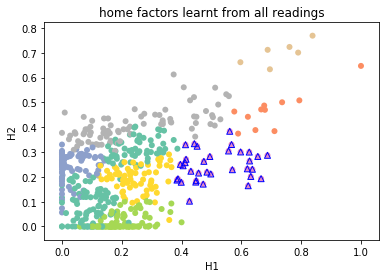

In [4]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

start = len(tensor)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, x1], X[:, x2], c = cluster, cmap='Set2', lw=0)
plt.xlabel("H1")
plt.ylabel("H2")
plt.title("home factors learnt from all readings")

target_cluster_id = 4
target_cluster_idx = [i for i, j in enumerate(cluster) if j == target_cluster_id]

ax.scatter(X[target_cluster_idx, x1], X[target_cluster_idx, x2], color='blue', marker='^', facecolors='none')



In [5]:
import random
random.seed(10)
random.shuffle(target_cluster_idx)
test_idx = target_cluster_idx[:6]
validate_idx = target_cluster_idx[6:12]

test_validate_idx = np.r_[test_idx, validate_idx]
train_idx = list(set(list(range(533))) - set(test_validate_idx))

In [6]:
train_ix = df.index[train_idx]
test_ix = df.index[test_idx]
validate_ix = df.index[validate_idx]


idx = np.r_[test_ix, validate_ix, train_ix]
df_t = df.loc[idx]
tensor = get_tensor(df_t, 1, 13)
L_inner = L[np.ix_(np.r_[test_validate_idx, train_idx], np.r_[test_validate_idx, train_idx])]

In [7]:
print test_ix
print validate_ix

Int64Index([8589, 499, 2365, 1202, 9295, 9939], dtype='int64')
Int64Index([7117, 6412, 5568, 7951, 4135, 484], dtype='int64')


In [172]:
from sklearn.metrics.pairwise import cosine_similarity

num_home_factor = 3
num_season_factor = 3

num_test = len(test_ix)
num_validate = len(validate_ix)
num_train = len(train_ix)

num_iterations = 10

train_df = df.loc[train_ix]
test_validate_df = df.loc[np.r_[test_ix, validate_ix]]

train_tensor = get_tensor(train_df, 1, 13)
test_validate_tensor = get_tensor(test_validate_df, 1, 13)

L_train = L[np.ix_(train_idx, train_idx)]
L_test_validate = L[np.ix_(test_validate_idx, test_validate_idx)]

ttv_df = df.loc[np.r_[train_ix, test_ix, validate_ix]]
ttv_tensor = get_tensor(ttv_df, 1, 13)

ttv_idx = np.r_[train_idx, test_idx, validate_idx]
L_ttv = L[np.ix_(ttv_idx, ttv_idx)]

weight_matrices = {}
train_weight = np.ones(train_tensor.shape)

H = {}
A = {}
T = {}



choose = "max"


for method in ['with', 'without', 'app']:
    H[method] = {}
    A[method] = {}
    T[method] = {}
    weight_matrices[method] = {}
    pred[method] = {}
    pred_validation[method] = {}
    error[method] = {}
    for iterations in range(num_iterations):
        pred[method][iterations] = {}
        pred_validation[method][iterations] = {}
        error[method][iterations] = {}
        for appliance in APPLIANCES_ORDER:
            pred[method][iterations][appliance] = []
            pred_validation[method][iterations][appliance] = []
            error[method][iterations][appliance] = []
            
tv_weight = np.ones(test_validate_tensor.shape)
print tv_weight.shape

(12, 7, 12)


In [173]:
# jointly
for method in ['with', 'without', 'app']:
    train_weight = np.ones(train_tensor.shape)
    for iteration in range(num_iterations):
        print method, "iteration: ", iteration

        weight = np.r_[train_weight, tv_weight]

        weight_matrices[method][iteration] = weight
        tensor_copy = ttv_tensor.copy()
        tensor_copy[num_train:(num_train + num_test), 1: , :] = np.NaN

        # do tensor factorization
        H_ttv, A_ttv, T_ttv, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                   L_ttv,
                                                                  num_home_factor,
                                                                  num_season_factor,
                                                                 weight, num_iter=3000,
                                                                  lr=0.1, dis=True,
                                                                  lam=0,
                                                                  T_known=T_constant)


        HAT = multiply_case(H_ttv, A_ttv, T_ttv, 2)
        for appliance in APPLIANCES_ORDER[1:]:
            pred[method][iteration][appliance].append(pd.DataFrame(HAT[num_train:(num_train + num_test), appliance_index[appliance], :], index = test_ix))
            pred_validation[method][iteration][appliance].append(pd.DataFrame(HAT[(num_train + num_test):, appliance_index[appliance], :], index = validate_ix))

        # compute the appliance prediction error for each validation homes
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred_validation[method][iteration][appliance]).loc[validate_ix]
            if appliance=="hvac":
                error[method][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[3]
            else:   
                error[method][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[3]


        # compute the average appliance error for each home
        error_avg = {}
        for appliance in APPLIANCES_ORDER[1:]:

            if appliance == 'hvac':
                start, end = 5, 11
            else:
                start, end = 1, 13

            error_home = pd.concat([error[method][iteration][appliance][appliance + "_{}".format(start)], 
                               error[method][iteration][appliance][appliance + "_{}".format(start+1)]],axis=1)

            for i in range(start+2, end):
                error_home = pd.concat([error_home, error[method][iteration][appliance][appliance + "_{}".format(i)]], axis=1)
            app = np.sqrt((error_home**2).mean(axis=1))
            error_avg[appliance] = app
        error_overall = (pd.DataFrame(error_avg).fillna(0)*pd.Series(contri['Austin'])).sum(axis=1)

        validate_importance = pd.DataFrame(error_overall).reindex(validate_ix).T.as_matrix()

        # use the Home factors to update the weight matrix
        similarities = cosine_similarity(H_ttv)
        sim = similarities[:num_train, (num_train + num_test):]
        ####

        #######
        if method == 'app':
            error_app_v = pd.DataFrame(error_avg).reindex(validate_ix).as_matrix()
            sim_app = np.nanmax(np.einsum('ab, bc -> abc', sim, error_app_v), axis=1)
            sim_app = (sim_app - sim_app.min(axis= 0)) / (sim_app.max(axis=0) - sim_app.min(axis=0))
            w = np.c_[np.ones(len(sim_app)), sim_app]
            train_weight = np.repeat(w, 12, axis=1).reshape(-1, 7, 12)    
        else:
            
            if method == 'with':
                w = sim*validate_importance
            else:
                w = sim
            w = w.max(axis=1)
            w = (w - w.min())/(w.max() - w.min())
            train_weight = np.repeat(w.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)

        H[method][iteration] = H_ttv
        A[method][iteration] = A_ttv
        T[method][iteration] = T_ttv

with iteration:  0
500.484029263
140.600136553
101.474417731
89.158481481
83.344060479
80.1053938221
with iteration:  1
386.078358176
107.623963481
78.185639476
69.5499639356
66.0023549315
63.8941683144
with iteration:  2
359.827789827
100.71680683
72.438695986
65.292211498
62.1785099409
60.2443121785
with iteration:  3
365.97847471
102.876043301
73.7854828796
66.2594845516
63.0645465783
61.0941149663
with iteration:  4
363.935498519
102.307116095
73.4153903666
65.9956413159
62.8084157161
60.8420817744
with iteration:  5
366.78076539
103.331858382
74.1505237186
66.516952454
63.3062823669
61.3068318713
with iteration:  6
363.069451423
102.091734556
73.2975851487
65.8964603777
62.7064698042
60.7356088679
with iteration:  7
367.251244189
103.451247435
74.2260633184
66.5767270529
63.3645332415
61.3678496739
with iteration:  8
362.83838744
102.028936928
73.2579727432
65.8671225247
62.6789800676
60.7077391464
with iteration:  9
367.312459931
103.463812283
74.2325310533
66.5823654221
63.37045

### Home factors and weights

0.964827312991
0.0
0.961524468638
0.0
0.959649076424
0.0
0.959713109088
0.0
0.959769699471
0.0


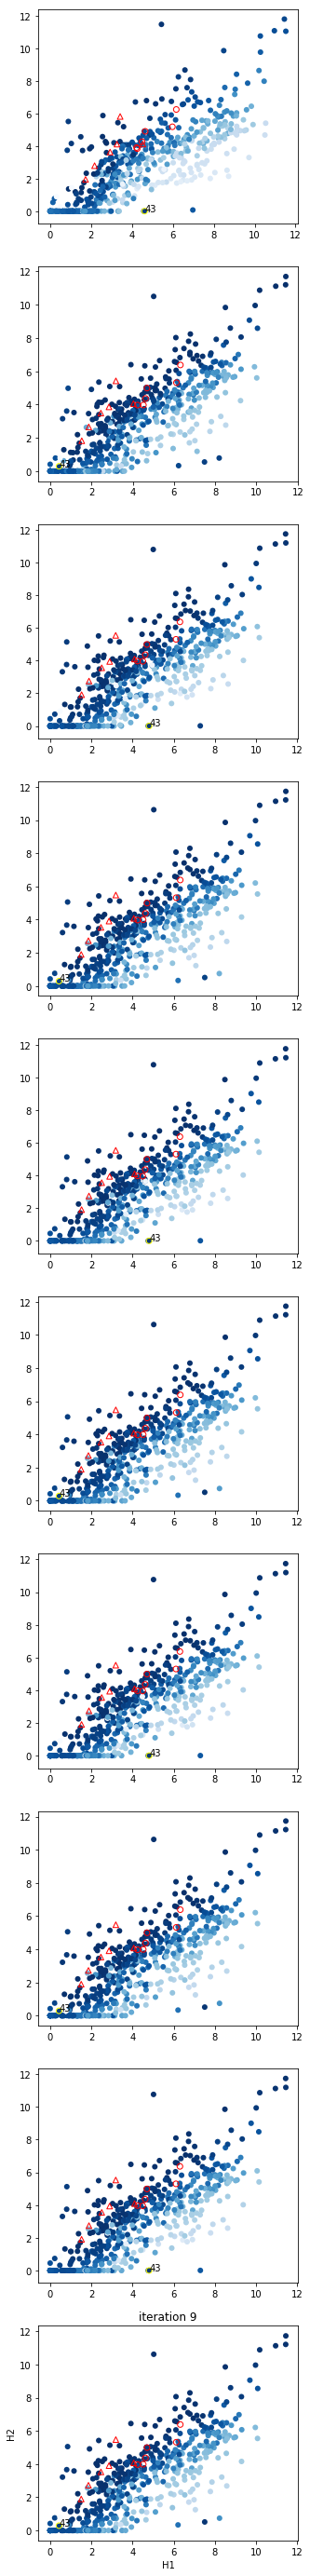

In [115]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))

method = 'without'
for iteration in range(0, num_iterations, 1):
    X = H[method][iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
    x1 = 2
    x2 = 0
    
    train_sim = weight_matrices[method][iteration][:].mean(axis=1).mean(axis=1)
    print train_sim[43]
    axes[iteration].scatter(X[:num_train, x1], X[:num_train, x2], c = train_sim[:num_train], cmap='Blues', lw=0)
    axes[iteration].scatter(X[num_train:(num_train + num_test), x1], X[num_train:(num_train + num_test), x2], color='red', marker='o', facecolors='none')
    axes[iteration].scatter(X[(num_test+num_train):, x1], X[(num_test + num_train):, x2], color='red', marker='^', facecolors='none')
    for i in [43]:
        axes[iteration].annotate(i, (X[i, x1],X[i, x2]))
        axes[iteration].scatter(X[i, x1], X[i, x2], color='yellow', marker='o', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
    plt.title('iteration {}'.format(iteration))


### test homes

In [174]:

out= {}

for method in ['with', 'without', 'app']:
    out[method] = {}
    for iteration in range(num_iterations):
        print iteration
        out[method][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred[method][iteration][appliance]).loc[test_ix]
            print appliance
            try:
                if appliance=="hvac":
                    out[method][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out[method][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]
            except Exception, e:
                print (e)

0
hvac
fridge
mw
dw
wm
oven
1
hvac
fridge
mw
dw
wm
oven
2
hvac
fridge
mw
dw
wm
oven
3
hvac
fridge
mw
dw
wm
oven
4
hvac
fridge
mw
dw
wm
oven
5
hvac
fridge
mw
dw
wm
oven
6
hvac
fridge
mw
dw
wm
oven
7
hvac
fridge
mw
dw
wm
oven
8
hvac
fridge
mw
dw
wm
oven
9
hvac
fridge
mw
dw
wm
oven
0
hvac
fridge
mw
dw
wm
oven
1
hvac
fridge
mw
dw
wm
oven
2
hvac
fridge
mw
dw
wm
oven
3
hvac
fridge
mw
dw
wm
oven
4
hvac
fridge
mw
dw
wm
oven
5
hvac
fridge
mw
dw
wm
oven
6
hvac
fridge
mw
dw
wm
oven
7
hvac
fridge
mw
dw
wm
oven
8
hvac
fridge
mw
dw
wm
oven
9
hvac
fridge
mw
dw
wm
oven
0
hvac
fridge
mw
dw
wm
oven
1
hvac
fridge
mw
dw
wm
oven
2
hvac
fridge
mw
dw
wm
oven
3
hvac
fridge
mw
dw
wm
oven
4
hvac
fridge
mw
dw
wm
oven
5
hvac
fridge
mw
dw
wm
oven
6
hvac
fridge
mw
dw
wm
oven
7
hvac
fridge
mw
dw
wm
oven
8
hvac
fridge
mw
dw
wm
oven
9
hvac
fridge
mw
dw
wm
oven


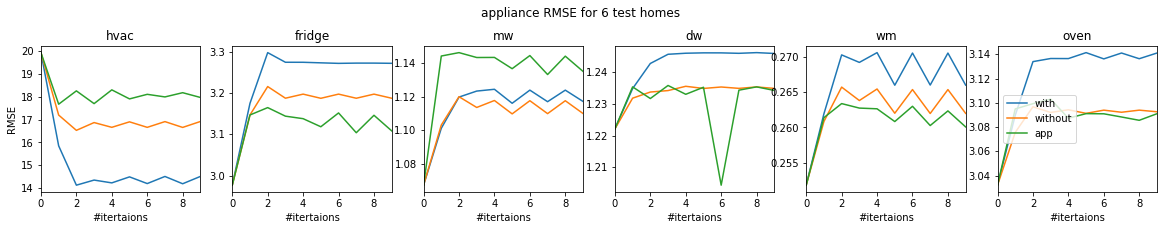

In [176]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out = {}
for method in ['with', 'without', 'app']:
    mean_out[method] = pd.DataFrame(out[method])

for appliance in APPLIANCES_ORDER[1:]:
#     mean_out_v['same']['max'].T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out['independent'].T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out['jointly'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out['with'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out['without'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out['app'].T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['max'].T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['min'].T[appliance].plot(ax = ax[count], title=appliance)
    
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
ax[count-1].legend(['with', 'without', 'app'], loc='center left')
plt.suptitle("appliance RMSE for 6 test homes")
fig.subplots_adjust(top=0.8)


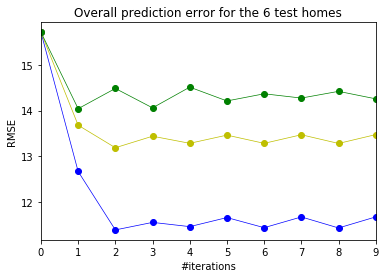

In [177]:
ig, ax = plt.subplots()
error = {}
error['with'] = (mean_out['with'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['with'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])

error['without'] = (mean_out['without'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['without'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['y'])

error['app'] = (mean_out['app'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['app'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['g'])

ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 test homes")



In [142]:
k = pd.DataFrame(error_avg).reindex(validate_ix).as_matrix()[:, :5]

In [143]:
sim.shape
k.shape

(6, 5)

In [153]:
tmp = np.nanmax(np.einsum('ab, bc -> abc', sim, k), axis=1)

In [158]:
tmp = (tmp - tmp.min(axis= 0)) / (tmp.max(axis=0) - tmp.min(axis=0))

In [171]:
k = np.c_[np.ones(len(tmp)), tmp]
k

array([[ 1.        ,  0.49487042,  0.51213152,  0.49487042,  0.48961874,
         0.47811835],
       [ 1.        ,  0.66461708,  0.56771316,  0.66461708,  0.70164515,
         0.75825577],
       [ 1.        ,  0.51735214,  0.53557247,  0.51735214,  0.51160057,
         0.49906647],
       ..., 
       [ 1.        ,  0.28885899,  0.21013571,  0.28885899,  0.31994316,
         0.36971507],
       [ 1.        ,  0.60171048,  0.57420819,  0.60171048,  0.61475918,
         0.6332412 ],
       [ 1.        ,  0.3575381 ,  0.27186599,  0.3575381 ,  0.39129492,
         0.44501867]])

In [169]:
np.repeat(k, 12, axis =1).reshape(-1, 6, 12)

array([[[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.49487042,  0.49487042,  0.49487042, ...,  0.49487042,
          0.49487042,  0.49487042],
        [ 0.51213152,  0.51213152,  0.51213152, ...,  0.51213152,
          0.51213152,  0.51213152],
        [ 0.49487042,  0.49487042,  0.49487042, ...,  0.49487042,
          0.49487042,  0.49487042],
        [ 0.48961874,  0.48961874,  0.48961874, ...,  0.48961874,
          0.48961874,  0.48961874],
        [ 0.47811835,  0.47811835,  0.47811835, ...,  0.47811835,
          0.47811835,  0.47811835]],

       [[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.66461708,  0.66461708,  0.66461708, ...,  0.66461708,
          0.66461708,  0.66461708],
        [ 0.56771316,  0.56771316,  0.56771316, ...,  0.56771316,
          0.56771316,  0.56771316],
        [ 0.66461708,  0.66461708,  0.66461708, ...,  0.66461708,
          0.66

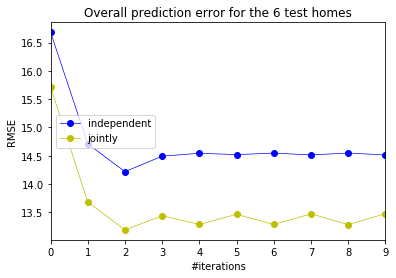

In [215]:
fig, ax = plt.subplots()
error = {}
error['independent'] = (mean_out['independent'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['independent'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])

error['jointly'] = (mean_out['jointly'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['jointly'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['y'])

ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 test homes")
ax.legend(['independent', 'jointly'], loc='center left')

plt.savefig("overall-RMSE_test_jointly.pdf", format='pdf')

### validation homes

In [138]:
out_v = {}

for choice in ['max']:
    out_v[choice] = {}
    for iteration in range(num_iterations):
        print choice, iteration
        out_v[choice][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred_validation[iteration][appliance]).loc[validate_ix]
            print appliance
            try:
                if appliance=="hvac":
                    out_v[choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out_v[choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]
            except Exception, e:
                print (e)

max 0
hvac
fridge
mw
dw
wm
oven
max 1
hvac
fridge
mw
dw
wm
oven
max 2
hvac
fridge
mw
dw
wm
oven
max 3
hvac
fridge
mw
dw
wm
oven
max 4
hvac
fridge
mw
dw
wm
oven
max 5
hvac
fridge
mw
dw
wm
oven
max 6
hvac
fridge
mw
dw
wm
oven
max 7
hvac
fridge
mw
dw
wm
oven
max 8
hvac
fridge
mw
dw
wm
oven
max 9
hvac
fridge
mw
dw
wm
oven
max 10
hvac
fridge
mw
dw
wm
oven
max 11
hvac
fridge
mw
dw
wm
oven
max 12
hvac
fridge
mw
dw
wm
oven
max 13
hvac
fridge
mw
dw
wm
oven
max 14
hvac
fridge
mw
dw
wm
oven
max 15
hvac
fridge
mw
dw
wm
oven
max 16
hvac
fridge
mw
dw
wm
oven
max 17
hvac
fridge
mw
dw
wm
oven
max 18
hvac
fridge
mw
dw
wm
oven
max 19
hvac
fridge
mw
dw
wm
oven


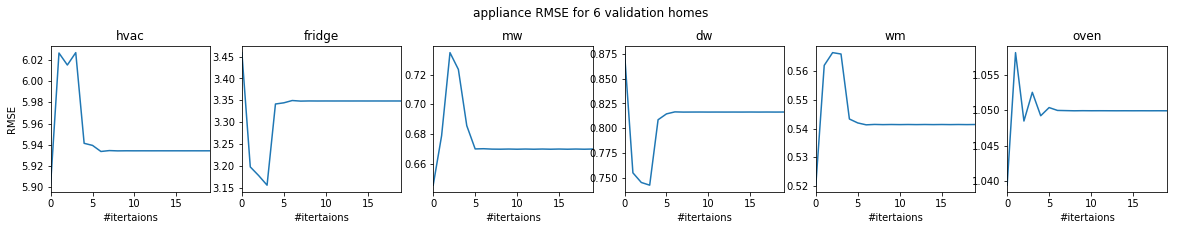

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out_v = pd.DataFrame(out_v['max'])
       
for appliance in APPLIANCES_ORDER[1:]:
#     mean_out_v['same']['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out_v.T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['max'].T[appliance].plot(ax = ax[count], title=appliance)
#     mean_out_v['diff']['min'].T[appliance].plot(ax = ax[count], title=appliance)
    
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
# ax[count-1].legend(['same cluster', 'different cluster'], loc='center left')
plt.suptitle("appliance RMSE for 6 validation homes")
fig.subplots_adjust(top=0.8)
# plt.savefig("appliance-RMSE_test_same_diff.pdf", format='pdf')

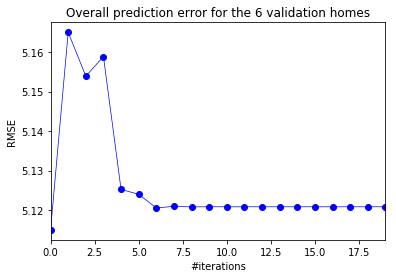

In [149]:
fig, ax = plt.subplots()
error_v = {}
error_v = (mean_out_v.T*pd.Series(contri['Austin'])).sum(axis=1)
error_v.plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])

ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 validation homes")
# plt.savefig("overall-RMSE_validate.pdf", format='pdf')

In [112]:
out_v = {}
for tv_type in ['same', 'diff']:
    out_v[tv_type] = {}
    for choice in ['max', 'min']:
        out_v[tv_type][choice] = {}
        for iteration in range(num_iterations):
            print tv_type, choice, iteration
            out_v[tv_type][choice][iteration] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                if tv_type == 'same':
                    s = pd.concat(pred[tv_type][choice][iteration][appliance]).loc[test_ix]
                else: 
                    s = pd.concat(pred[tv_type][choice][iteration][appliance]).loc[test_ix]
                if appliance=="hvac":
                    out_v[tv_type][choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out_v[tv_type][choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

same max 0
same max 1
same max 2
same max 3
same max 4
same max 5
same max 6
same max 7
same max 8
same max 9
same max 10
same max 11
same max 12
same max 13
same max 14
same max 15
same max 16
same max 17
same max 18
same max 19
same min 0
same min 1
same min 2
same min 3
same min 4
same min 5
same min 6
same min 7
same min 8
same min 9
same min 10
same min 11
same min 12
same min 13
same min 14
same min 15
same min 16
same min 17
same min 18
same min 19
diff max 0
diff max 1
diff max 2
diff max 3
diff max 4
diff max 5
diff max 6
diff max 7
diff max 8
diff max 9
diff max 10
diff max 11
diff max 12
diff max 13
diff max 14
diff max 15
diff max 16
diff max 17
diff max 18
diff max 19
diff min 0
diff min 1
diff min 2
diff min 3
diff min 4
diff min 5
diff min 6
diff min 7
diff min 8
diff min 9
diff min 10
diff min 11
diff min 12
diff min 13
diff min 14
diff min 15
diff min 16
diff min 17
diff min 18
diff min 19


KeyError: 'min'

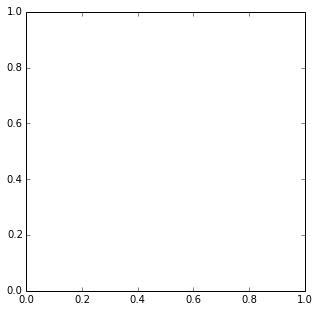

In [117]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 50))
fig, ax = plt.subplots(figsize=(5,5))
choice = "min"
for iteration in [6]:
    X = H[choice][iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
#     x1 = 2
#     x2 = 0
    
    train_sim = weight_matrices[choice][iteration][:].mean(axis=1).mean(axis=1)
    ax.scatter(X[(num_test+num_validate):, x1], X[(num_test+num_validate):, x2], c = train_sim, cmap='Blues', lw=0)
    ax.scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    ax.scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='red', marker='^', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
    ax.set_title("iteration {}". format(iteration))
    
    plt.savefig("weight_iteration_6_{}.pdf".format(choice), format='pdf')
#     axes[iteration/2].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='c_id, weight')
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")

### test homes

In [49]:
out = {}
for choice in ['max', 'min']:
    out[choice] = {}
    for iteration in range(num_iterations):
        out[choice][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred[choice][iteration][appliance]).loc[test_ix]
            if appliance=="hvac":
                out[choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
            else:   
                out[choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

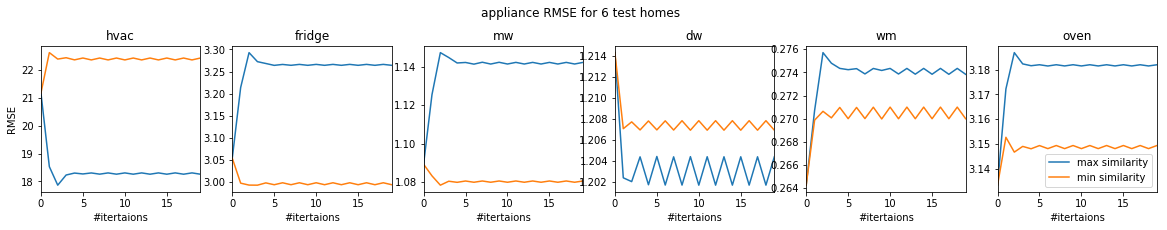

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out = {}
mean_out['min'] = pd.DataFrame(out['min'])
mean_out['max'] = pd.DataFrame(out['max'])

for appliance in APPLIANCES_ORDER[1:]:
    mean_out['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out['min'].T[appliance].plot(ax = ax[count], title=appliance)
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
ax[count-1].legend(['max similarity', 'min similarity'])
plt.suptitle("appliance RMSE for 6 test homes")
fig.subplots_adjust(top=0.8)
plt.savefig("appliance-RMSE_test.pdf", format='pdf')

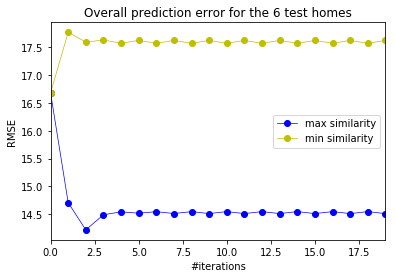

In [102]:
fig, ax = plt.subplots()
error['max'] = (mean_out['max'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['max'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])
error['min'] = (mean_out['min'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['min'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['y'])
ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 test homes")
ax.legend(['max similarity', 'min similarity'])
plt.savefig("overall-RMSE_test.pdf", format='pdf')

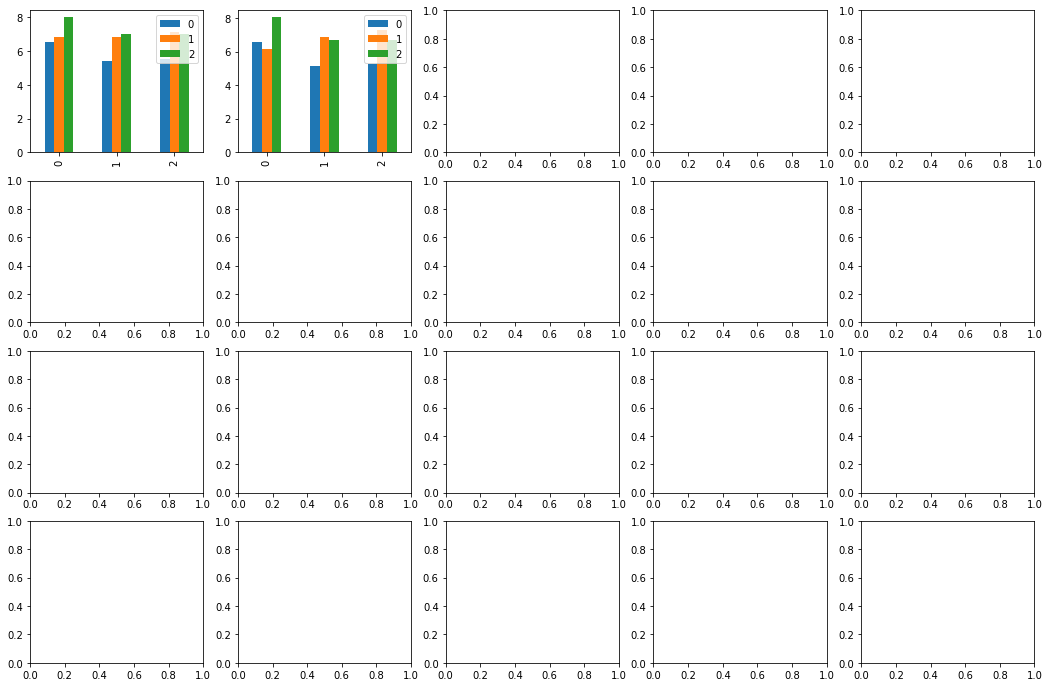

In [101]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18,12))


pd.DataFrame(A['max'][2][0]).plot(ax=axes[0][0], kind='bar')
pd.DataFrame(A['min'][2][0]).plot(ax=axes[0][1], kind='bar')


In [26]:
for iteration in [1]:
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
#     print sim_df
    for i in set(cluster):
        print i
        sub_cluster = sim_df.loc[sim_df[0] == i]
#         print sub_cluster[1]
        print sub_cluster[1].mean(axis=0)
    

0
0.720437494274
1
0.0135169107494
2
0.85064710518
3
0.782826517102
4
0.586187154995
5
0.968014577588
6
0.824718495544
7
0.919507619139
8
0.529737241121
9
0.349787779521


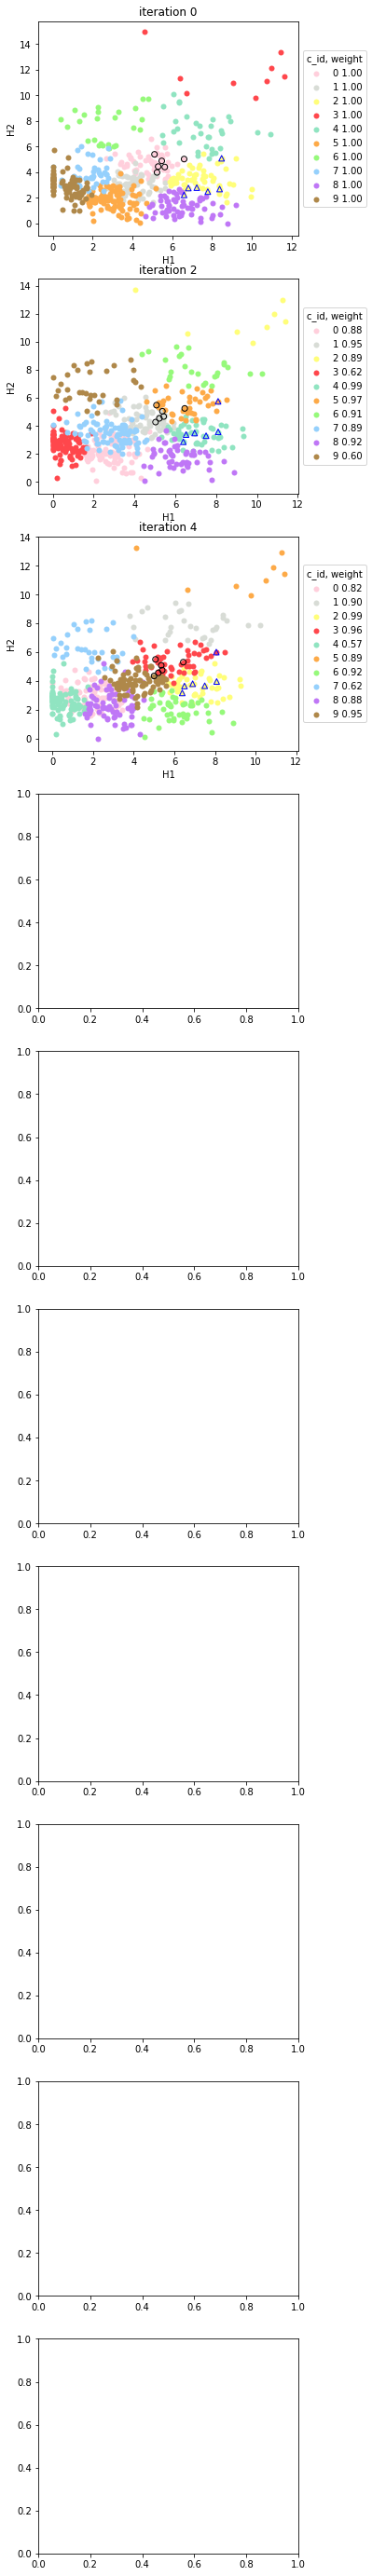

In [127]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))

colors = ['#ffcfdc', '#d8dcd6', '#fffe7a', '#ff474c', '#90e4c1', '#fdaa48', '#96f97b', '#95d0fc', '#bf77f6', '#af884a']
for iteration in range(0, num_iterations, 2):
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
    x1 = 2
    x2 = 0
    
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
    
    for c_id in set(cluster):
        
        sub_cluster = sim_df.loc[sim_df[0] == c_id]
        mean_sim = format(sub_cluster[1].mean(axis=0), '.2f')
        
        index = [i for i,j in enumerate(cluster) if j == c_id]
        train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
        axes[iteration/2].scatter(X[index, x1], X[index, x2], c = colors[c_id], lw=0, label="{} {}".format(c_id, mean_sim))
    axes[iteration/2].scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    axes[iteration/2].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='blue', marker='^', facecolors='none')
    axes[iteration/2].set_xlabel("H1")
    axes[iteration/2].set_ylabel("H2")
    axes[iteration/2].set_title("iteration {}". format(iteration))
    axes[iteration/2].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='c_id, weight')
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")